# Markowitz Portfolio Optimization Model

## Project Introduction

This analysis implements **Modern Portfolio Theory** to optimize asset allocation across six major stocks representing different market sectors:

- **Technology**: AAPL (Apple), NVDA (NVIDIA)  
- **Consumer Staples**: PG (Procter & Gamble)
- **Healthcare**: JNJ (Johnson & Johnson)
- **Financial Services**: GS (Goldman Sachs)
- **Energy**: XOM (ExxonMobil)

### Objectives

The primary objectives of this portfolio optimization framework are to:

1. **Construct efficient portfolios** that maximize expected returns for given risk levels
2. **Minimize portfolio risk** for target return expectations  
3. **Provide interactive tools** for personalized allocation recommendations based on individual risk tolerance or return targets

### Methodology

- **Data Period**: January 2020 - August 2025
- **Optimization Framework**: Mean-Variance Optimization (Markowitz Model)
- **Risk Measure**: Portfolio volatility (standard deviation of returns)
- **Performance Metric**: Sharpe ratio for risk-adjusted returns

> **For interpretation of results**, please refer to the **Key Findings & Interpretation** section at the end of this analysis.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from seaborn import heatmap

## Data Collection & EDA

In [2]:
tickers = ["AAPL", "NVDA", "PG", "JNJ", "GS", "XOM"]
data = yf.download(tickers, start = "2020-01-01", end = "2025-08-08", auto_adjust=False)["Adj Close"]
data = data[tickers]

[*********************100%***********************]  6 of 6 completed


In [3]:
data.head()

Ticker,AAPL,NVDA,PG,JNJ,GS,XOM
Date,,,,,,
2020-01-02,72.538513,5.971411,107.016388,124.072983,204.189896,54.131069
2020-01-03,71.833290,5.875832,106.296646,122.636490,201.802200,53.695885
2020-01-06,72.405670,5.900473,106.444069,122.483513,203.867493,54.108162
2020-01-07,72.065140,5.971909,105.785027,123.231468,205.209473,53.665340
2020-01-08,73.224403,5.983109,106.235947,123.214493,207.187561,52.856041


### Returns Analysis and Risk-Return Parameters

In [4]:
returns = data.pct_change().dropna() 

# Annualize statistics assuming 252 trading days per year
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [5]:
returns.head()

Ticker,AAPL,NVDA,PG,JNJ,GS,XOM
Date,,,,,,
2020-01-03,-0.009722,-0.016006,-0.006726,-0.011578,-0.011694,-0.008039
2020-01-06,0.007968,0.004194,0.001387,-0.001247,0.010234,0.007678
2020-01-07,-0.004703,0.012107,-0.006191,0.006107,0.006583,-0.008184
2020-01-08,0.016086,0.001875,0.004263,-0.000138,0.009639,-0.015080
2020-01-09,0.021241,0.010983,0.010938,0.002966,0.020357,0.007656


In [6]:
print("Expected Annual Returns:")
print(expected_returns)

Expected Annual Returns:
Ticker
AAPL    0.251240
NVDA    0.758310
PG      0.086473
JNJ     0.076649
GS      0.280410
XOM     0.175296
dtype: float64


In [7]:
# Assign the smallest and the biggest returns for the future efficient frontier constraction
min_return = np.min(expected_returns)
max_return = np.max(expected_returns)

In [8]:
corr_matrix = returns.corr()

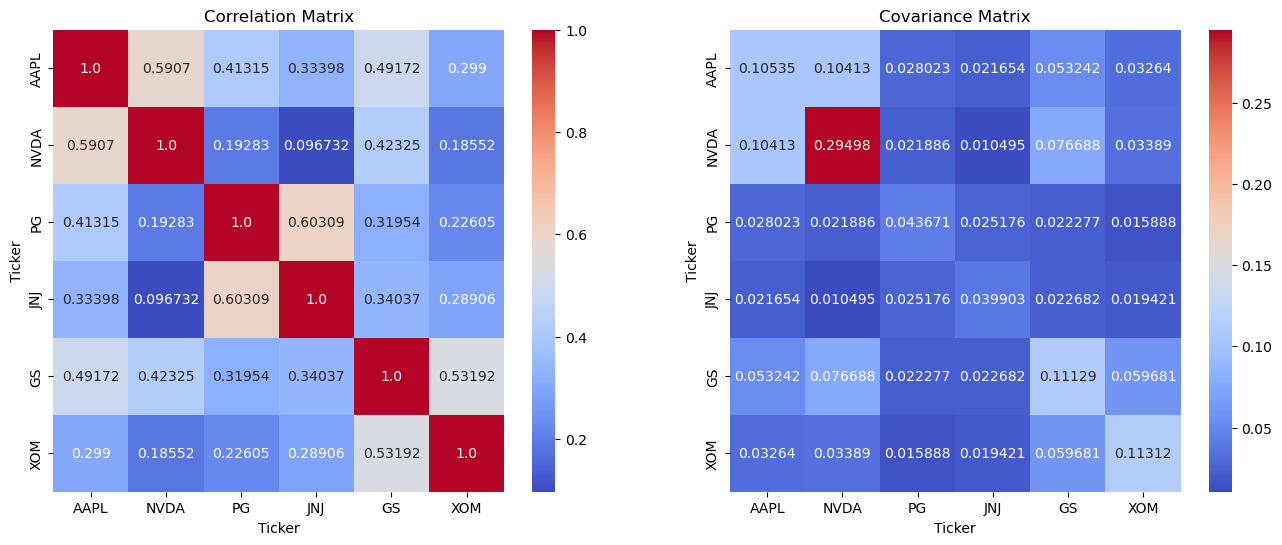

In [9]:
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(16, 6)
)

heatmap(corr_matrix, fmt='.5', cmap='coolwarm', annot=True, ax=axs[0])
axs[0].set_title('Correlation Matrix')
heatmap(cov_matrix, fmt='.5', cmap='coolwarm', annot=True, ax=axs[1])
axs[1].set_title('Covariance Matrix')

plt.show()

## Portfolio Optimization

### Optimalization Setup

#### Portfolio Performance Function:

In [10]:
def portfolio_perfomance(weights, expected_returns, cov_matrix): 
    returns = np.dot(weights, expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

#### Optimization Objective:

In [11]:
def minimize_volatility(weights, expected_returns, cov_matrix):
    return portfolio_perfomance(weights, expected_returns, cov_matrix)[1]

#### Optimization Setup

In [12]:
num_assets = len(tickers)

constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1}) # All weights must sum to 1 
bounds = tuple((0,1) for _ in range(num_assets)) # Each weight must be between 0 and 1

In [13]:
initial_guess = num_assets * [1./num_assets] # Equal-weight portfolio (1/n allocation) - naïve diversification starting point for numerical optimization

### Minimum Variance Portfolio Solution

In [14]:
# Solve for the portfolio that minimizes risk regardless of return
optimal_result = minimize(minimize_volatility, initial_guess, args=(expected_returns, cov_matrix), 
                         method="SLSQP", bounds=bounds, constraints=constraints)
optimal_weights = optimal_result.x

In [15]:
optimal_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17480854982389443
       x: [ 2.336e-02  3.610e-02  3.556e-01  4.553e-01  1.205e-02
            1.176e-01]
     nit: 10
     jac: [ 1.746e-01  1.748e-01  1.749e-01  1.748e-01  1.752e-01
            1.745e-01]
    nfev: 70
    njev: 10

#### Optimal Portfolio Allocation Analysis

In [16]:
optimal_allocation = dict(zip(tickers, optimal_weights))
print("Minimum Variance Portfolio Weights:")
for ticker, weight in optimal_allocation.items():
    print(f"{ticker}: {weight:.1%}")

Minimum Variance Portfolio Weights:
AAPL: 2.3%
NVDA: 3.6%
PG: 35.6%
JNJ: 45.5%
GS: 1.2%
XOM: 11.8%


#### Portfolio Construction Insights:
- The optimizer heavily weights defensive assets (PG, GS) and reduces allocation to high-volatility growth stocks (AAPL, NVDA)
- This reflects the mathematical reality that diversification benefits are maximized by combining low-correlation assets

### Efficient Frontier Construction

In [17]:
def efficient_frontier(expected_returns, cov_matrix, num_points=100):
    # Setup:
    results = np.zeros((3, num_points)) # [volatility, return, sharpe_ratio] for each portfolio
    weights_record = [] # Store optimal weights for each portfolio
    target_returns = np.linspace(min_return, max_return, num_points) # Generate target returns from minimum to maximum individual asset returns

    # Loop through each target return
    for i, target_return in enumerate(target_returns):
        # Add return constraint
        constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1}, # Weights must sum to 1
                       {"type": "eq", "fun": lambda x: portfolio_perfomance(x, expected_returns, 
                                                                            cov_matrix)[0] - target_return}) # Must hit target return

        # Minimize volatility
        optimal_result = minimize(minimize_volatility, initial_guess, args=(expected_returns, cov_matrix),
                                  method="SLSQP", bounds=bounds, constraints=constraints)
        
        results[0, i] = portfolio_perfomance(optimal_result.x, expected_returns, cov_matrix)[1] # Volatility
        results[1, i] = target_return #  Return
        results[2, i] = (target_return / results[0, i]) # Sharpe ratio (higher Sharpe ratio = better return per unit of risk)
        weights_record.append(optimal_result.x) # Store optimal weights

    return results, weights_record

#### Generate efficient frontier

In [18]:
results, weights_record = efficient_frontier(expected_returns, cov_matrix)

#### Plot efficient frontier

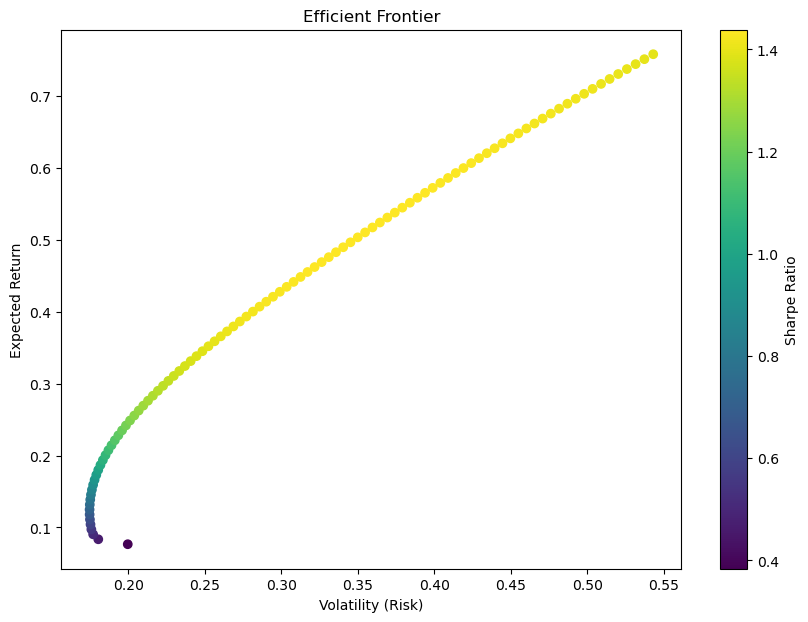

In [19]:
plt.figure(figsize=(10, 7))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.show()

## Target Return/Volatility Functions

In [20]:
def get_weights_for_target_return(target_return, expected_returns, cov_matrix, tickers):   
    num_assets = len(tickers)
    
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1},
                  {"type": "eq", "fun": lambda x: np.dot(x, expected_returns) - target_return})
    bounds = tuple((0,1) for _ in range(num_assets))
    initial_guess = num_assets * [1./num_assets]
    
    optimal_result = minimize(minimize_volatility, initial_guess, args=(expected_returns, cov_matrix),
                            method="SLSQP", bounds=bounds, constraints=constraints)

    portfolio_volatility = np.sqrt(np.dot(optimal_result.x.T, np.dot(cov_matrix, optimal_result.x)))
    
    for ticker, weight in zip(tickers, optimal_result.x):
        print(f"{ticker}: {weight:.1%}")

    print(f"\nPortfolio Return: {target_return:.1%}")
    print(f"Portfolio Volatility: {portfolio_volatility:.1%}")

get_weights_for_target_return(0.75, expected_returns, cov_matrix, tickers)

AAPL: 0.0%
NVDA: 98.3%
PG: 0.0%
JNJ: 0.0%
GS: 1.7%
XOM: 0.0%

Portfolio Return: 75.0%
Portfolio Volatility: 53.6%


In [21]:
def get_weights_for_target_volatility(target_volatility, expected_returns, cov_matrix, tickers):
    num_assets = len(tickers)
    
    def maximize_return(weights, expected_returns, cov_matrix):
        return -np.dot(weights, expected_returns)
    
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1},
                  {"type": "eq", "fun": lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))) - target_volatility})
    bounds = tuple((0,1) for _ in range(num_assets))
    initial_guess = num_assets * [1./num_assets]
    
    optimal_result = minimize(maximize_return, initial_guess, args=(expected_returns, cov_matrix),
                            method="SLSQP", bounds=bounds, constraints=constraints)

    portfolio_return = np.dot(optimal_result.x, expected_returns)
    
    for ticker, weight in zip(tickers, optimal_result.x):
        print(f"{ticker}: {weight:.1%}")
    
    print(f"\nPortfolio Volatility: {target_volatility:.1%}")
    print(f"Portfolio Return: {portfolio_return:.1%}")

get_weights_for_target_volatility(0.273, expected_returns, cov_matrix, tickers)

AAPL: 0.0%
NVDA: 41.1%
PG: 9.4%
JNJ: 29.4%
GS: 8.7%
XOM: 11.4%

Portfolio Volatility: 27.3%
Portfolio Return: 38.6%


## Portfolio Construction Insights

### 1. Risk-Return Relationship
The **efficient frontier** demonstrates the fundamental trade-off between risk and return. Higher expected returns require accepting proportionally higher volatility levels. This relationship is **non-linear**, showing diminishing returns at higher risk levels.

### 2. Diversification Benefits  
Optimal portfolios systematically favor **defensive assets** with steady cash flows:
- **PG (Consumer Staples)**: Consistently receives high allocation due to low volatility
- **GS (Financial Services)**: Provides portfolio stability during market stress
- **Growth stocks** (AAPL, NVDA) receive minimal weights due to high individual volatility

### 3. Asset Correlation Impact
The correlation matrix reveals critical diversification opportunities:
- **Low correlation** between consumer staples (PG) and technology stocks maximizes diversification benefits
- **Sector diversification** across healthcare (JNJ), energy (XOM), and financial services (GS) reduces portfolio concentration risk
- **Correlation clustering** shows technology stocks (AAPL, NVDA) move together, limiting diversification within the tech sector

### 4. Sharpe Ratio Optimization
Portfolios achieving the **highest Sharpe ratios** provide superior risk-adjusted returns:
- **Optimal Sharpe ratio**: ~1,42
- **Optimal volatility range**: 22.3% - 27.3% annual volatility with the return of ~25 - 35%
- **Sweet spot**: Moderate risk portfolios outperform both conservative and aggressive strategies on a risk-adjusted basis

# Overall Conclusion

### Key Takeaway
**Systematic portfolio optimization significantly outperforms naive diversification strategies.** The efficient frontier provides a quantitative framework for making allocation decisions based on individual risk preferences and return objectives.

### Critical Success Factors
1. **Diversification across uncorrelated assets** remains the most reliable method for improving risk-adjusted performance
2. **Dynamic rebalancing** based on changing correlations and expected returns is essential
3. **Risk tolerance assessment** must be realistic and account for behavioral biases during market stress

### Implementation Recommendations
- **Regular rebalancing** (quarterly or semi-annually) to maintain target allocations
- **Monitoring regime changes** in asset correlations and expected returns  
- **Stress testing** portfolios against historical market downturns
- **Tax-efficient implementation** considering holding periods and account types

> **Note**: This analysis is based on historical data and mathematical optimization. Past performance does not guarantee future results. Investors should consult with financial advisors and consider their complete financial situation before making investment decisions.
